In [ ]:
#Stands Imps
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.python.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import ReduceLROnPlateau


In [ ]:
#Define useful paths
path_content = '/content'
path_master = '/content/all'
path_drive = '/content/drive/My Drive/'
path_datasets = '/content/drive/My Drive/Datasets'
path_mask = '/content/mask'

In [ ]:
#My needed things
ch_dir_content()
%run -i '/content/drive/My Drive/imports.py'

In [ ]:
#Extract images from zip folder
from zipfile import ZipFile
ch_dir_content()
os.mkdir('all')

with ZipFile("/content/drive/My Drive/Datasets/sat_final_r.zip") as zipsat2:
  
  # Extract all the contents of zip file in different directory
  zipsat2.extractall('/content/all')

In [ ]:
#Read in master file
master = pd.read_csv(path_datasets+'/'+'master_finalr.csv', index_col=0)

#Split into train, test, valid
df = master[master.target <= 9000]
df = master[master.target >= 2000]
df = shuffle(df)

train_num = int(0.7*len(df))
valid_num = int(0.2*len(df))
test_num  = int(0.1*len(df))

#Create train, valid & test sets
train_df = df.iloc[0:train_num]
valid_df = df.iloc[train_num:train_num+valid_num]
test_df  = df.iloc[train_num+valid_num:]

In [ ]:
#Create generators for iterative training
path = path_master

def preprocess_images(img):
  return exposure.equalize_adapthist(img/255)

train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_images)
test_valid_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_images)

#Define image shape 
r = 300
w = 300 
c = 3

#Define training generator
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=path,
        x_col="filename",
        y_col="target",
        target_size=(r, w),
        batch_size=30,
        #color_mode='grayscale',
        class_mode='raw')

#Define valid generator
validation_generator = test_valid_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=path,
        x_col="filename",
        y_col="target",
        #color_mode='grayscale',
        target_size=(r, w),
        batch_size=20,
        class_mode='raw')

#Define valid generator
test_generator = test_valid_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=path,
        x_col="filename",
        y_col="target",
        target_size=(r, w),
        #color_mode='grayscale',
        batch_size=20,
        class_mode='raw')

Found 12009 validated image filenames.
Found 3431 validated image filenames.
Found 1717 validated image filenames.


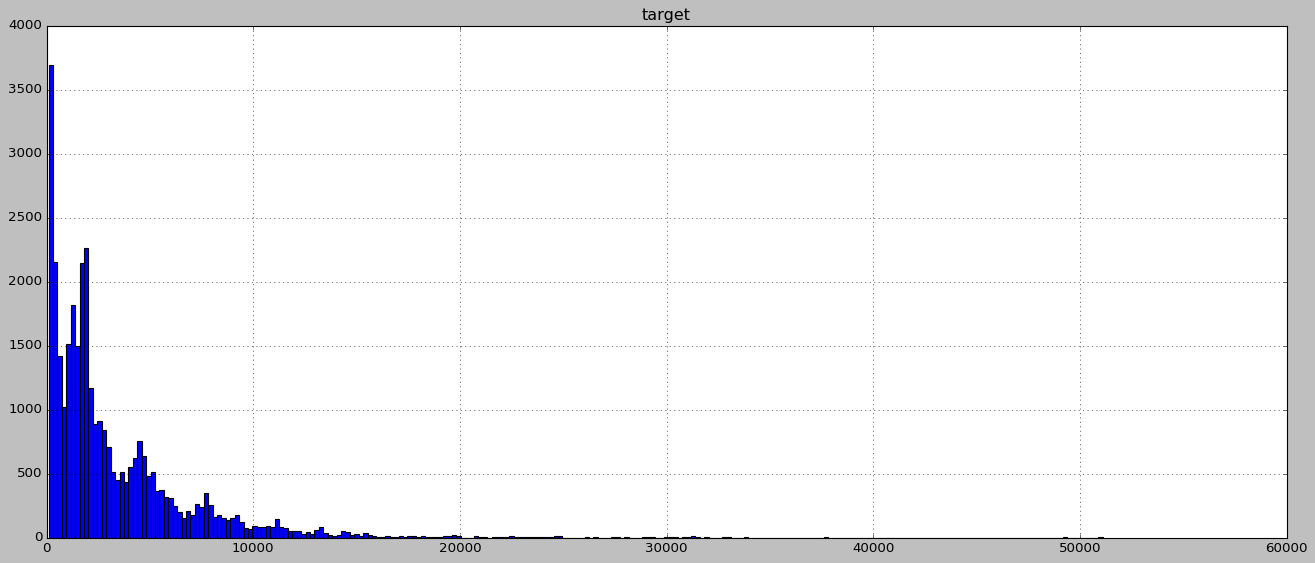

In [ ]:
plot_df_hist(master, 'target')

In [ ]:
def res_block(x, y, filter, kernel):

  #Convolve with stride 1 to retain dims and pass activations
  res = tf.keras.layers.Conv2D(kernel_size=kernel, filters=filter, strides=1, padding='same', activation='relu')(x)
  res = tf.keras.layers.BatchNormalization()(res)

  #2 convolves serve for identity mapping
  res = tf.keras.layers.Conv2D(kernel_size=kernel, filters=filter, strides=1, padding='same', activation='relu')(res)
  
  #Add the skip connection to the desired layer
  res = tf.keras.layers.Add()([y, res])
  res = tf.keras.layers.BatchNormalization()(res)
  
  return res

In [ ]:
#Construct model architecture
K.clear_session()
sat_images = Input(shape=(300,300,3))
b = BatchNormalization()(sat_images)

x1 = Conv2D(filters=24, kernel_size=9, strides = 2, activation='relu',padding='same')(b)
d = Dropout(rate=0.15)(x1)
x2 = Conv2D(filters=24, kernel_size=(5,5), strides=1, activation='relu',padding='same')(d)
r = res_block(x1, x2, 24, 3)
d = Dropout(rate=0.2)(r)

x3 = Conv2D(filters=24, kernel_size=3, strides=2, activation='relu', padding='same')(d)
x4 = Conv2D(filters=24, kernel_size=1, strides=1, activation='relu', padding='same')(x3)
r = res_block(x3, x4, 24, 3)
d = Dropout(rate=0.15)(r)

#Fully Connected
f = Flatten()(d)
D = Dense(150, activation='relu')(f)

#Output layer
output = Dense(1, activation='linear', name='Pop_Est')(D)

#Create model
model = Model(inputs=sat_images, outputs=output)

#Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mean_absolute_percentage_error')
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 300, 300, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 24) 5856        batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 150, 150, 24) 5208        conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
#Fit model
history = model.fit(
          train_generator,
          steps_per_epoch=int(len(train_df)/30),
          epochs=10,
          validation_data=validation_generator,
          validation_steps=int(len(valid_df)/20))
                

Epoch 1/10
400/400 [==============================] - 871s 2s/step - loss: 30.0295 - val_loss: 31.2632
Epoch 2/10
400/400 [==============================] - 819s 2s/step - loss: 29.6668 - val_loss: 32.6370
Epoch 3/10
400/400 [==============================] - 819s 2s/step - loss: 29.2012 - val_loss: 35.7644
Epoch 4/10
400/400 [==============================] - 814s 2s/step - loss: 28.7671 - val_loss: 32.4788
Epoch 5/10
400/400 [==============================] - 820s 2s/step - loss: 28.4732 - val_loss: 32.4837
Epoch 6/10
400/400 [==============================] - 811s 2s/step - loss: 28.0147 - val_loss: 31.4400
Epoch 7/10
400/400 [==============================] - 829s 2s/step - loss: 27.7527 - val_loss: 31.7557
Epoch 8/10
292/400 [====================>.........] - ETA: 2:51 - loss: 27.4201